In [7]:
!pip install -q ultralytics kagglehub opencv-python-headless matplotlib pillow pyyaml

In [8]:
import os
import shutil
import yaml
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
from ultralytics import YOLO
from google.colab import files

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"awaishashar","key":"f8984e448ae28242479954436f7d8c94"}'}

In [10]:
yawn_path = kagglehub.dataset_download("davidvazquezcic/yawn-dataset")
print("Yawn dataset path:", yawn_path)

100%|██████████| 16.9M/16.9M [00:00<00:00, 139MB/s]

Extracting files...


Yawn dataset path: /root/.cache/kagglehub/datasets/davidvazquezcic/yawn-dataset/versions/1


In [11]:
facial_path = kagglehub.dataset_download("osmankagankurnaz/facial-feature-extraction-dataset")
print("Facial features dataset path:", facial_path)

100%|██████████| 24.5M/24.5M [00:00<00:00, 112MB/s]

Extracting files...


Facial features dataset path: /root/.cache/kagglehub/datasets/osmankagankurnaz/facial-feature-extraction-dataset/versions/1


In [12]:
fingers_path = kagglehub.dataset_download("koryakinp/fingers")
print("Fingers dataset path:", fingers_path)

100%|██████████| 363M/363M [00:06<00:00, 60.2MB/s]

Extracting files...


Fingers dataset path: /root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2


In [13]:
base_dir = Path("/content/combined_dataset")
base_dir.mkdir(exist_ok=True)

(base_dir / "images" / "train").mkdir(parents=True, exist_ok=True)
(base_dir / "images" / "val").mkdir(parents=True, exist_ok=True)
(base_dir / "labels" / "train").mkdir(parents=True, exist_ok=True)
(base_dir / "labels" / "val").mkdir(parents=True, exist_ok=True)

print("Dataset structure created")

Dataset structure created


In [14]:
def copy_yolo_dataset(source_path, dest_base, class_mapping=None):
    source = Path(source_path)

    for split in ['train', 'valid']:
        split_name = 'val' if split == 'valid' else split

        img_src = source / split / 'images'
        lbl_src = source / split / 'labels'

        if not img_src.exists() or not lbl_src.exists():
            continue

        for img_file in img_src.glob('*.*'):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                shutil.copy(img_file, dest_base / 'images' / split_name / img_file.name)

                lbl_file = lbl_src / f"{img_file.stem}.txt"
                if lbl_file.exists():
                    if class_mapping:
                        with open(lbl_file, 'r') as f:
                            lines = f.readlines()

                        new_lines = []
                        for line in lines:
                            parts = line.strip().split()
                            if parts:
                                old_class = int(parts[0])
                                if old_class in class_mapping:
                                    parts[0] = str(class_mapping[old_class])
                                    new_lines.append(' '.join(parts) + '\n')

                        with open(dest_base / 'labels' / split_name / lbl_file.name, 'w') as f:
                            f.writelines(new_lines)
                    else:
                        shutil.copy(lbl_file, dest_base / 'labels' / split_name / lbl_file.name)

print("Dataset copy function ready")

Dataset copy function ready


In [15]:
yawn_versions = list(Path(yawn_path).glob('versions/*'))
if yawn_versions:
    yawn_data_path = yawn_versions[0]
else:
    yawn_data_path = Path(yawn_path)

copy_yolo_dataset(yawn_data_path, base_dir, class_mapping={0: 0})
print("Yawn dataset copied (class 0: yawn)")

Yawn dataset copied (class 0: yawn)


In [16]:
facial_versions = list(Path(facial_path).glob('versions/*'))
if facial_versions:
    facial_data_path = facial_versions[0]
else:
    facial_data_path = Path(facial_path)

facial_class_mapping = {
    2: 1,
    3: 2
}

copy_yolo_dataset(facial_data_path, base_dir, class_mapping=facial_class_mapping)
print("Facial features dataset copied (class 1: nose, class 2: mouth)")

Facial features dataset copied (class 1: nose, class 2: mouth)


In [17]:
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

fingers_data_path = Path(fingers_path)
train_path = fingers_data_path / 'versions' / '1' / 'train'
test_path = fingers_data_path / 'versions' / '1' / 'test'

if not train_path.exists():
    train_path = fingers_data_path / 'train'
    test_path = fingers_data_path / 'test'


def create_finger_annotations(img_path, output_img_path, output_lbl_path):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False

    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return False

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    img_h, img_w = img.shape
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    width = w / img_w
    height = h / img_h

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(str(output_img_path), img_rgb)

    with open(output_lbl_path, 'w') as f:
        f.write(f"3 {x_center} {y_center} {width} {height}\n")

    return True

finger_count_train = 0
finger_count_val = 0
max_fingers_train = 1500
max_fingers_val = 500

# Process training images
if train_path.exists():
    for img_file in train_path.glob('*.png'):
        if finger_count_train >= max_fingers_train:
            break

        output_img = base_dir / 'images' / 'train' / f"finger_{img_file.stem}.jpg"
        output_lbl = base_dir / 'labels' / 'train' / f"finger_{img_file.stem}.txt"

        if create_finger_annotations(img_file, output_img, output_lbl):
            finger_count_train += 1

# Process validation images
if test_path.exists():
    for img_file in test_path.glob('*.png'):
        if finger_count_val >= max_fingers_val:
            break

        output_img = base_dir / 'images' / 'val' / f"finger_{img_file.stem}.jpg"
        output_lbl = base_dir / 'labels' / 'val' / f"finger_{img_file.stem}.txt"

        if create_finger_annotations(img_file, output_img, output_lbl):
            finger_count_val += 1


print(f"Fingers dataset processed: {finger_count_train} training images, {finger_count_val} validation images (class 3: finger)")

Fingers dataset processed: 1500 training images, 500 validation images (class 3: finger)


In [18]:
data_yaml = {
    'path': str(base_dir),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 4,
    'names': ['yawn', 'nose', 'mouth', 'finger']
}

yaml_path = base_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("data.yaml created")
print(f"Classes: {data_yaml['names']}")

data.yaml created
Classes: ['yawn', 'nose', 'mouth', 'finger']


In [19]:
train_images = len(list((base_dir / 'images' / 'train').glob('*.*')))
val_images = len(list((base_dir / 'images' / 'val').glob('*.*')))
train_labels = len(list((base_dir / 'labels' / 'train').glob('*.txt')))
val_labels = len(list((base_dir / 'labels' / 'val').glob('*.txt')))

print(f"Training images: {train_images}")
print(f"Training labels: {train_labels}")
print(f"Validation images: {val_images}")
print(f"Validation labels: {val_labels}")

Training images: 1500
Training labels: 1500
Validation images: 500
Validation labels: 500


In [20]:
model = YOLO('yolov8m.pt')
print("YOLOv8m model loaded")

YOLOv8m model loaded


In [21]:
results = model.train(
    data=str(yaml_path),
    epochs=50,
    imgsz=640,
    batch=16,
    patience=10,
    save=True,
    device=0,
    project='yolo_training',
    name='detection_model',
    exist_ok=True
)

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/combined_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detection_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=

In [22]:
metrics = model.val()

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 267.7±82.5 MB/s, size: 5.1 KB)
val: Scanning /content/combined_dataset/labels/val.cache... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 930.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 2.3it/s 14.0s
                   all        500        500          1          1      0.995      0.995
                finger        500        500          1          1      0.995      0.995
Speed: 1.5ms preprocess, 23.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val


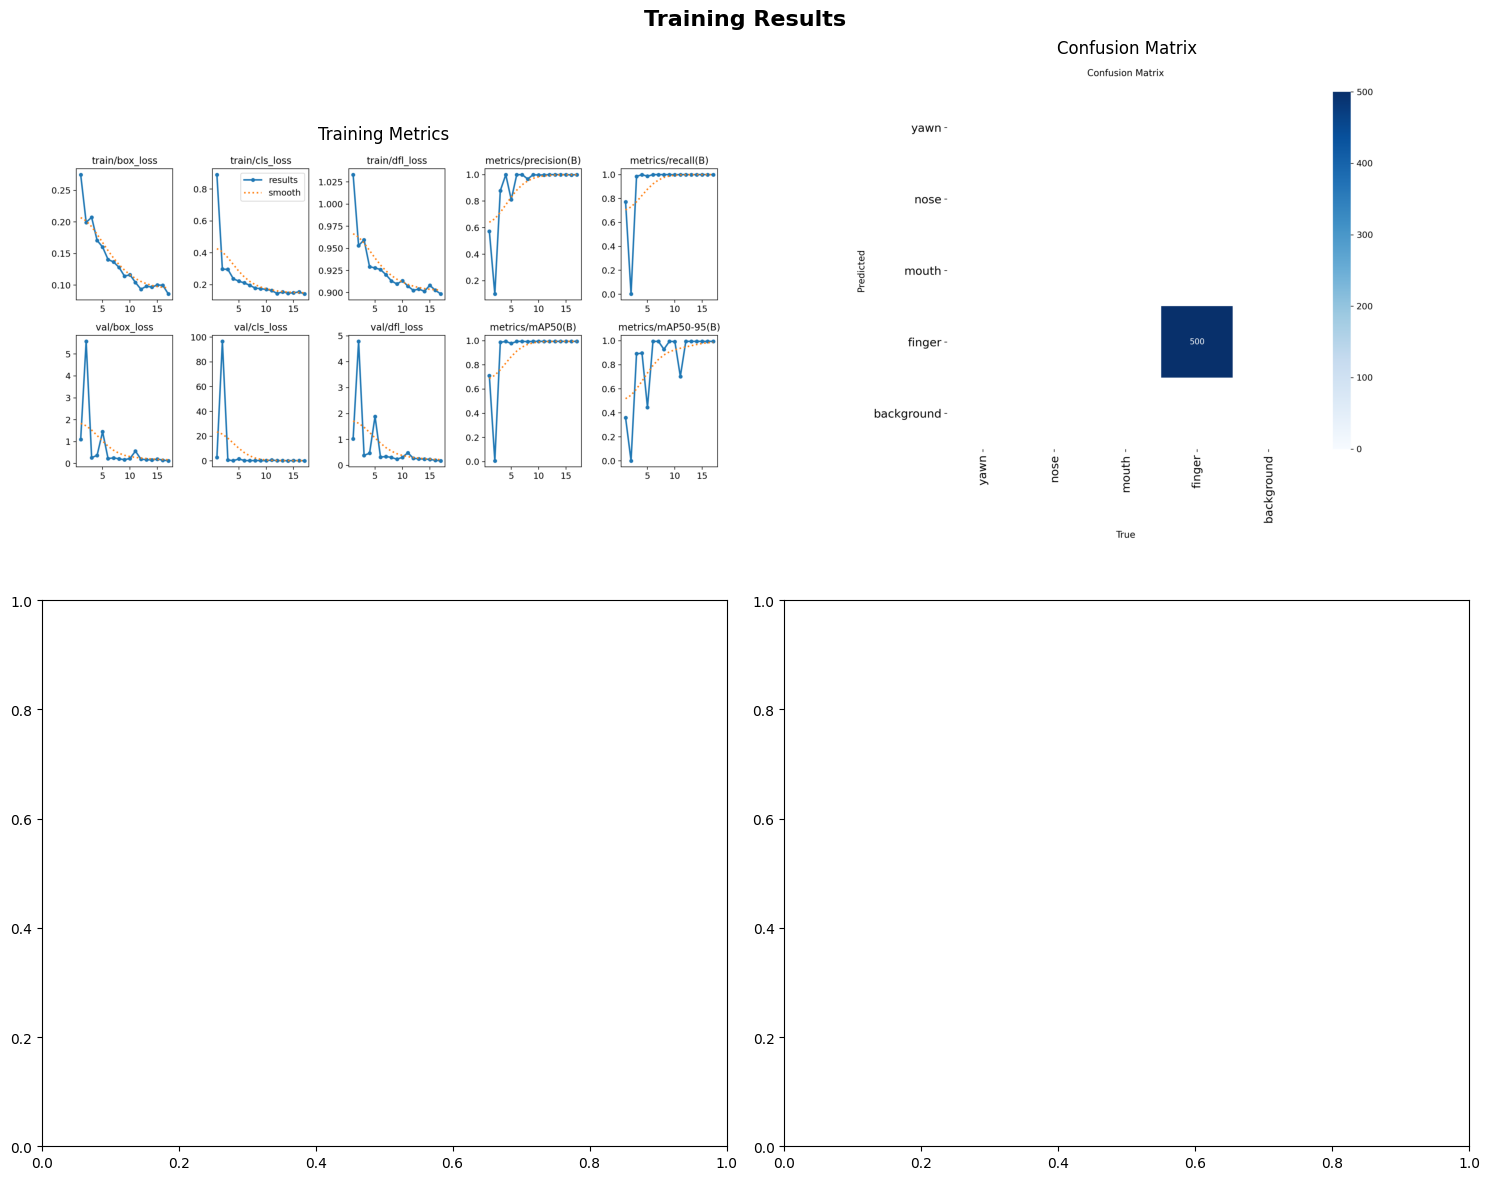


Training Summary:
mAP50: 0.9950
mAP50-95: 0.9950
Precision: 0.9999
Recall: 1.0000


In [23]:
results_dir = Path('yolo_training/detection_model')

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Results', fontsize=16, fontweight='bold')

results_img = results_dir / 'results.png'
if results_img.exists():
    img = plt.imread(results_img)
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Training Metrics')
    axes[0, 0].axis('off')

confusion_matrix = results_dir / 'confusion_matrix.png'
if confusion_matrix.exists():
    img = plt.imread(confusion_matrix)
    axes[0, 1].imshow(img)
    axes[0, 1].set_title('Confusion Matrix')
    axes[0, 1].axis('off')

pr_curve = results_dir / 'PR_curve.png'
if pr_curve.exists():
    img = plt.imread(pr_curve)
    axes[1, 0].imshow(img)
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].axis('off')

f1_curve = results_dir / 'F1_curve.png'
if f1_curve.exists():
    img = plt.imread(f1_curve)
    axes[1, 1].imshow(img)
    axes[1, 1].set_title('F1 Score Curve')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining Summary:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

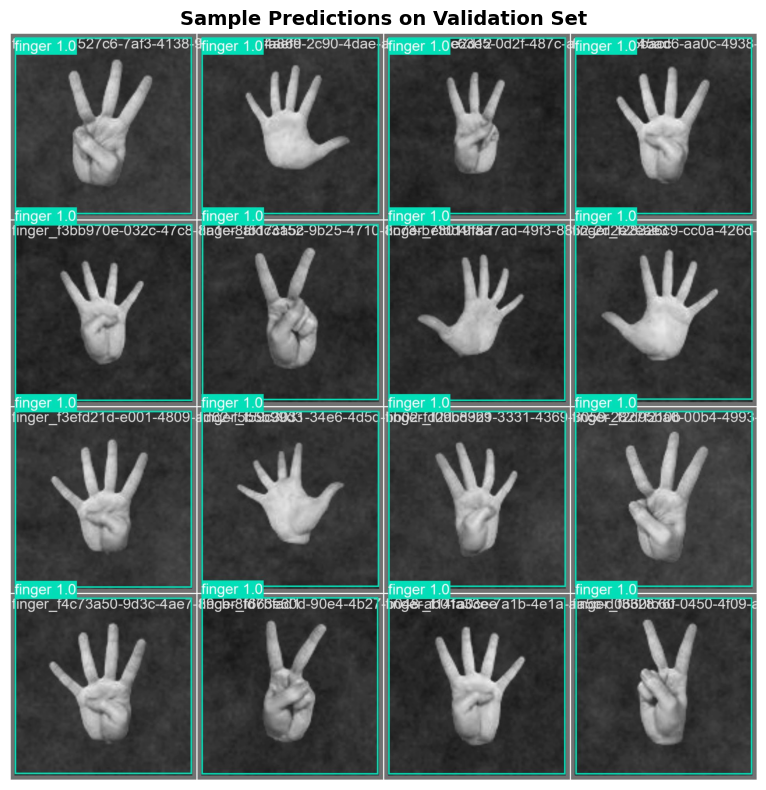

In [24]:
val_batch = results_dir / 'val_batch0_pred.jpg'
if val_batch.exists():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    img = plt.imread(val_batch)
    ax.imshow(img)
    ax.set_title('Sample Predictions on Validation Set', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [25]:
model_save_path = Path('yolo_detection_model.pt')
best_model_path = results_dir / 'weights' / 'best.pt'

if best_model_path.exists():
    shutil.copy(best_model_path, model_save_path)
    print(f"Model saved to: {model_save_path}")
    print(f"Model size: {model_save_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print("Error: Best model not found")

Model saved to: yolo_detection_model.pt
Model size: 49.62 MB


In [26]:
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"\nModel saved: yolo_detection_model.pt")
print(f"\nDetected classes:")
print("  0: yawn")
print("  1: nose")
print("  2: mouth")
print("  3: finger")
print(f"\nFinal metrics:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")
print("\nReady for OpenCV integration")


TRAINING COMPLETE

Model saved: yolo_detection_model.pt

Detected classes:
  0: yawn
  1: nose
  2: mouth
  3: finger

Final metrics:
  mAP50: 0.9950
  mAP50-95: 0.9950
  Precision: 0.9999
  Recall: 1.0000

Ready for OpenCV integration
